In [1]:
import numpy as np

np.set_printoptions(threshold=10000, suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('PubMed-multi-label-dataset.csv', sep=',', encoding="utf-8")
data.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0


In [3]:
corpus = data['abstractText']

### Proposer un code qui permettra d’apprendre votre propre modèle de plongement lexical Word2Vec sur vos données textuelles. Évaluer visuellement et numériquement sur quelques mots clés votre nouveau modèle de vectorisation (Embedding).

In [5]:
import numpy as np
from collections import defaultdict
from nltk.tokenize import word_tokenize
from tqdm import trange

tokenized_corpus = [word_tokenize(sentence.lower()) for sentence in corpus]

vector_size = 100
window_size = 2
learning_rate = 0.025
epochs = 10

word_vectors = defaultdict(lambda: np.random.uniform(-0.25, 0.25, vector_size))

def update_word_vector(target, context, learning_rate):
    error = word_vectors[context] - word_vectors[target]
    word_vectors[target] += learning_rate * error
    word_vectors[context] -= learning_rate * error

for epoch in trange(epochs):
    for sentence in tokenized_corpus:
        for target_index, target_word in enumerate(sentence):
            for context_word in sentence[max(0, target_index - window_size):target_index + window_size]:
                if target_word != context_word:
                    update_word_vector(target_word, context_word, learning_rate)

print(word_vectors["exemple"])


100%|██████████| 10/10 [19:43<00:00, 118.34s/it]

[ 0.23911419 -0.19947218 -0.03900346  0.24791787 -0.16272945  0.02549288
  0.02261281 -0.12669463  0.09444086 -0.19179251  0.10118469 -0.02630707
 -0.03271564 -0.15079389 -0.13209722  0.12361202  0.14452158  0.24339071
 -0.05101981  0.16176352 -0.11663991  0.11404389 -0.20394438 -0.19895031
  0.133777    0.23345155 -0.19938637 -0.0785221   0.10657596  0.08682682
  0.22374146 -0.10970144  0.21431806  0.14189793 -0.18678676  0.24470306
 -0.00379495  0.05236304  0.10152137  0.24092215 -0.15102755  0.15486018
 -0.18707086  0.02202562  0.041545    0.01047379  0.17137461 -0.19385595
 -0.02877016 -0.23311134 -0.12967579 -0.11445235  0.02497981  0.07659069
  0.06166982 -0.00187047 -0.20225776  0.02409772 -0.11706211 -0.03056227
 -0.1900595   0.23948908 -0.15752141  0.00674414 -0.23561266  0.12046446
 -0.11283675 -0.05560764  0.14793271  0.20284168 -0.14748068 -0.18833299
  0.03783544  0.00215748  0.21354432 -0.05006125 -0.07796609 -0.17282557
 -0.10403339 -0.1361026   0.10143219 -0.22014492  0

In [11]:
from sklearn.manifold import TSNE

def most_similar(word, word_vectors):
    word_vector = word_vectors[word]
    word_vectors_values = np.array(list(word_vectors.values()))
    distances = np.sqrt(np.sum((word_vectors_values - word_vector)**2, axis=1))
    idxs = np.argsort(distances)
    return [(list(word_vectors.keys())[i], distances[i]) for i in idxs[:10]]

def visualize_word_vectors(model, word):
    arr = np.empty((0, vector_size), dtype='f')
    word_labels = [word]

    close_words = most_similar(word, model)
    
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    tsne = TSNE(n_components=2, random_state=0, perplexity=5)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min() + 0.00005, x_coords.max() + 0.00005)
    plt.ylim(y_coords.min() + 0.00005, y_coords.max() + 0.00005)
    plt.show()
    

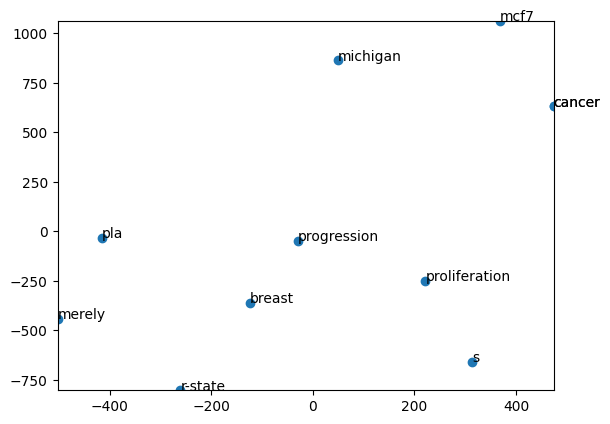

In [13]:
visualize_word_vectors(word_vectors, "cancer")

### Exploiter votre modèle Word2Vec pour la vectorisation de vos textes (avec deux méthodes utilisant ou non le TF-IDF des mots). Exécuter ensuite à nouveau votre fonction run_models sur vos données vectorisées par Word2Vec et interpréter les résultats obtenus en les comparant à ceux obtenus aux étapes précédentes. Vous pouvez vous inspirer de la fonction suivante :

In [14]:
## get word2vec for each sentence by using average word embeddings
def word2vec_generator(texts,model,vector_size): 
    dict_word2vec = {}
    for index, word_list in enumerate(texts):
        arr = np.array([0.0 for i in range(0, vector_size)]) 
        nb_word=0
        for word in word_list:
            try:
                arr += model[word] 
                nb_word=nb_word+1
            except KeyError: 
                continue
        if(len(word_list) == 0): 
            dict_word2vec[index] = arr
        else:
            dict_word2vec[index] = arr / nb_word
    df_word2vec = pd.DataFrame(dict_word2vec).T 
    return df_word2vec

In [15]:
df_word2vec = word2vec_generator(tokenized_corpus,word_vectors,vector_size)

In [24]:
with open('models/df_word2vec.pkl', 'wb') as f:
    pickle.dump(df_word2vec, f)

In [ ]:
with open('models/df_word2vec.pkl', 'rb') as f:
    df_word2vec = pickle.load(f)

In [21]:
from sklearn.multioutput import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import zero_one_loss
import pickle


def run_models(X_train, y_train, X_test, y_test, models, file_names=[]):
    for model in models:
        print(model)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Hamming loss: ", hamming_loss(y_test, y_pred))
        print("Zero-one loss: ", zero_one_loss(y_test, y_pred))
        print()
        if len(file_names) > 0:
            with open(file_names[models.index(model)], 'wb') as f:
                pickle.dump(model, f)

In [29]:
import gensim

## Apprentissage du Word2vec

In [30]:
corpus = corpus.apply(lambda line: gensim.utils.simple_preprocess((line)))

In [32]:
#Ici le code suivant a besoin de votre corpus de texte où chaque texte est tokenizé (une liste de tokens)

In [33]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

8

In [34]:
model_size = 100
model = gensim.models.Word2Vec(corpus, vector_size=model_size, sg=0, window=5, min_count=2, workers=cores - 1)

In [35]:
for i in range(100):
    model.train(corpus, total_examples=len(corpus), epochs=1)
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [37]:
model.save('models/Word2vec_entraine.h5')

In [93]:
model = gensim.models.Word2Vec.load('models/Word2vec_entraine.h5')

In [94]:
len(model.wv.index_to_key)

74651

In [95]:
model.wv['easy']

array([ 1.6654079 , -1.5034784 ,  0.5110981 , -4.1930223 ,  0.09314937,
        2.7616625 ,  0.04700468, -2.2822714 ,  0.03874538, -0.52443343,
       -2.8938997 ,  2.148002  , -1.9232304 , -0.06286446,  3.1893587 ,
       -5.270746  ,  0.32784304, -1.9411395 , -2.1714635 , -1.4288378 ,
       -1.5348532 ,  1.473419  , -2.1207361 ,  0.49881884, -2.9406567 ,
       -2.5208883 ,  2.3622885 ,  0.20641853, -0.25003427,  2.7113533 ,
        0.06382579, -4.113934  , -1.3935217 ,  1.0365883 ,  2.7860017 ,
       -0.5919349 , -0.7498196 ,  0.33379614,  1.523776  , -3.8976786 ,
        2.3132668 , -0.19561335,  1.0088341 , -0.07472833,  3.0608702 ,
        0.38650712, -3.7923768 ,  0.17576897, -0.504891  ,  0.8269976 ,
       -0.7221326 , -0.40463012,  0.8607108 ,  0.24683255, -1.3537418 ,
        0.23207827,  4.110492  ,  0.13510512,  4.179361  ,  1.4840094 ,
       -1.1553626 , -1.1207767 , -0.1877254 , -0.877413  ,  0.03301156,
        0.65108037, -2.92177   , -0.1319233 ,  1.240849  ,  1.33

In [53]:
model.wv.most_similar(positive='thanks', topn=10)

[('owing', 0.5255916118621826),
 ('ensure', 0.5067655444145203),
 ('accommodate', 0.5008588433265686),
 ('preserve', 0.4975113570690155),
 ('accomplish', 0.4673018157482147),
 ('due', 0.4569520950317383),
 ('pertaining', 0.4540463984012604),
 ('ascribe', 0.4397198259830475),
 ('itinerary', 0.4372483491897583),
 ('navigate', 0.43124091625213623)]

In [51]:
model.wv.doesnt_match(['food', 'drink', 'play'])

'play'

In [84]:
model.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)

[('lactate', 0.6244521141052246)]